# Categorifying and Normalization

**In this Notebook:**
* **Handling categorical features**
* **Scaling continuous features**
* **Transforming target feature**

In [1]:
# loading libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
import os
from tqdm import tqdm

from transform import TargetTransform   # custom class for handle target value transformation

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# setting paths
data_dir = os.path.abspath('./_data')
train_data_fp = os.path.join(data_dir, 'data.csv')
test_data_fp = os.path.join(data_dir, 'test.csv')
data_no_missing_fp = os.path.join(data_dir, 'data_no_missing.csv')
os.listdir(data_dir)

['data.csv',
 'data_clean.csv',
 'data_no_missing.csv',
 'test.csv',
 'test_clean.csv',
 'train_clean.csv']

In [3]:
# loading data-set
train_data = pd.read_csv(train_data_fp)
test_data = pd.read_csv(test_data_fp)
data = pd.read_csv(data_no_missing_fp)
n_train = len(train_data)
n_test = len(test_data)

In [4]:
print(f'Training data-set consists of {train_data.shape[0]} rows and {train_data.shape[1]} columns')
print(f'Test data-set consists of {test_data.shape[0]} rows and {test_data.shape[1]} columns')

Training data-set consists of 616656 rows and 20 columns
Test data-set consists of 154165 rows and 19 columns


In [5]:
# store target value and drop it from 'train_data'
market_share = train_data.loc[:, 'Market Share_total'].values
train_data.drop(columns=['Market Share_total'], inplace=True)
train_data.head(1)

,Unnamed: 0,Episode,Station,Channel Type,Season,Year,Date,Day of week,Start_time,End_time,Length,Name of show,Name of episode,Genre,First time or rerun,# of episode in the season,Movie?,Game of the Canadiens during episode?,Temperature in Montreal during episode
0,1,Vidéoclips V,V Total,General Channel,Fall,2016,2016-08-29,Monday,2016-08-29 06:00:00,2016-08-29 08:00:00,8,Vidéoclips V,NaN,Music Video Clips,No,Yes,No,No,20.4


In [6]:
data.head().T

,0,1,2,3,4
station,V Total,V Total,V Total,V Total,V Total
ch_type,General Channel,General Channel,General Channel,General Channel,General Channel
length,8,2,2,4,2
show_name,Vidéoclips V,Apollo dans l'frigo,Infopublicité,"Infos, Les","Souper presque parfait, Un"
genre,Music Video Clips,Informal Education and Recreation and Leisure,"Infomercials, Promotional and Corporate Videos",News,Reality Programs
first_or_rerun,No,No,No,No,No
episodes_in_season,Yes,Yes,Yes,Yes,Yes
is_movie,No,No,No,No,No
overlaped_with_game,No,No,No,No,No
temperature,20.4,19.125,19.125,18.125,18.25


## Dealling with categorical features

In [7]:
data.columns

Index(['station', 'ch_type', 'length', 'show_name', 'genre', 'first_or_rerun',
       'episodes_in_season', 'is_movie', 'overlaped_with_game', 'temperature',
       'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
       'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start',
       'Is_year_end', 'Is_year_start', 'Elapsed', 'running_time',
       'episode_name_na', 'temperature_na'],
      dtype='object')

In [8]:
to_drop = ['show_name', 'Week', 'Day', 'Dayofyear']


cat_names = ['station', 'ch_type', 'genre', 'first_or_rerun', 'episodes_in_season', 'is_movie',
             'overlaped_with_game', 'Year', 'Month', 'Dayofweek', 'Is_month_end', 'Is_month_start', 'Is_quarter_end',
             'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'episode_name_na', 'temperature_na']

cont_names = ['length', 'temperature', 'Elapsed', 'running_time']

In [9]:
# make sure all columns name listed
assert len(to_drop) + len(cat_names) + len(cont_names) == len(data.columns), "Not all columns listed"
print(True)

True


In [10]:
# drop unnecessary columns
data.drop(columns=to_drop, inplace=True)

In [11]:
print('Number of unique entries in categorical columns:')
for col in cat_names:
    print(f'{col}: {len(data[col].unique())}')

Number of unique entries in categorical columns:
station: 24
ch_type: 2
genre: 27
first_or_rerun: 2
episodes_in_season: 2
is_movie: 2
overlaped_with_game: 2
Year: 4
Month: 12
Dayofweek: 7
Is_month_end: 2
Is_month_start: 2
Is_quarter_end: 2
Is_quarter_start: 2
Is_year_end: 2
Is_year_start: 2
episode_name_na: 2
temperature_na: 2


In [12]:
def categorify(dataframe, cat_names):
    df = dataframe.copy()
    for col in tqdm(cat_names):
        # One Hot Encoding categorical columns with more than 2 categories
        if len(df[col].unique()) > 2:  
            dummies = pd.get_dummies(df[col], prefix=col)
            df = pd.concat(objs=[df, dummies], axis=1)
            df.drop(columns=[col], inplace=True)
        # Label encoding binary categorical columns
        elif len(df[col].unique()) == 2:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            del le    # delete the encoder object
            
    return df

In [13]:
# use the helper function for categorizing features
df_categorized = categorify(dataframe=data, cat_names=cat_names)

100%|████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.56it/s]


In [14]:
data.head().T

,0,1,2,3,4
station,V Total,V Total,V Total,V Total,V Total
ch_type,General Channel,General Channel,General Channel,General Channel,General Channel
length,8,2,2,4,2
genre,Music Video Clips,Informal Education and Recreation and Leisure,"Infomercials, Promotional and Corporate Videos",News,Reality Programs
first_or_rerun,No,No,No,No,No
episodes_in_season,Yes,Yes,Yes,Yes,Yes
is_movie,No,No,No,No,No
overlaped_with_game,No,No,No,No,No
temperature,20.4,19.125,19.125,18.125,18.25
Year,2016,2016,2016,2016,2016


In [15]:
df_categorized.columns

Index(['ch_type', 'length', 'first_or_rerun', 'episodes_in_season', 'is_movie',
       'overlaped_with_game', 'temperature', 'Is_month_end', 'Is_month_start',
       'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start',
       'Elapsed', 'running_time', 'episode_name_na', 'temperature_na',
       'station_ARTV+', 'station_Canal D+', 'station_Canal Vie+',
       'station_Evasion+', 'station_Historia+', 'station_LCN+', 'station_MAX+',
       'station_Meteomedia+', 'station_MusiquePlus+ (retired Aug 25, 2019)',
       'station_PYC Online Stream Fr CBC-8+',
       'station_PYC Online Stream Fr CBC-9+', 'station_RDI+', 'station_RDS+',
       'station_RDS2+', 'station_SRC Total', 'station_Series++',
       'station_TQ Total', 'station_TV5+', 'station_TVA Total',
       'station_Teletoon Fr.+', 'station_Unis TV+', 'station_V Total',
       'station_VRAK+', 'station_Z+', 'genre_Amateur Sports',
       'genre_Analysis and Interpretation',
       'genre_Animated Television Progra

### Scaling all features

In [16]:
# sc = StandardScaler()
# # applying standard-scaler to all features
# df_categorized_scaled = sc.fit_transform(df_categorized)

In [17]:
# # recreating a DataFrame from scaled values (np.ndarray)
# df_categorized_scaled = pd.DataFrame(df_categorized_scaled, columns=df_categorized.columns)

### Scaling continuos features only

In [18]:
def scale(dataframe, cont_names):
    df = dataframe.copy()
    sc = StandardScaler()
    cont_scaled = sc.fit_transform(df[cont_names])
    df[cont_names] = cont_scaled
    
    return df

In [19]:
# use the helper function to scale continuos features
df_categorized_scaled = scale(dataframe=df_categorized, cont_names=cont_names)

In [20]:
df_categorized_scaled[cont_names].head()

,length,temperature,Elapsed,running_time
0,0.906181,1.094244,-1.748154,0.886248
1,-0.223753,0.988957,-1.748154,-0.246226
2,-0.223753,0.988957,-1.748154,-0.246226
3,0.152892,0.906379,-1.748154,0.131266
4,-0.223753,0.916701,-1.748154,-0.246226


### Scaling the target feature

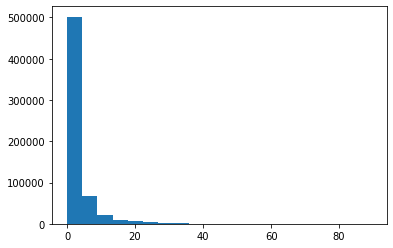

In [21]:
# plot the taget feature
plt.hist(market_share, bins=20)
plt.show()

**Target feature is highly skewed and need to be normalized before feeding to model.**

In [22]:
# create a new instance of TargetTransform class
tfms = TargetTransform(data=market_share, gamma=1e-3)

In [23]:
# use 'transform' method to normalize the skewed data
market_share_transformed = tfms.transform(market_share)

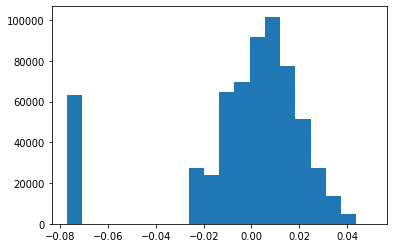

In [24]:
# plot the transformed data
plt.hist(market_share_transformed, bins=20)
plt.show()

In [25]:
# make sure inverse transformed values are equal to original values
market_share_inverse = tfms.inverse(market_share_transformed)

assert np.allclose(market_share_inverse, market_share) == True, "Inverse transformed data is not equal with original data."
print(True)

True


### Splitting train and test sets

In [26]:
df_categorized_scaled.shape

(770821, 91)

In [27]:
n_train, n_test

(616656, 154165)

In [28]:
# split preprocessed data into train and test sets
train_set = df_categorized_scaled.loc[0:n_train-1, :]
test_set = df_categorized_scaled.loc[n_train:, :]

In [29]:
# check size of sets
assert len(train_set) == n_train, "Train set size mismatched"
assert len(test_set) == n_test, "Test set size mismatched"

print('Everything is OK...')

Everything is OK...


In [30]:
# add taget feature back to train set
train_set = pd.concat(objs=[train_set,
                            pd.DataFrame({'market_share': market_share}),
                            pd.DataFrame({'market_share_transformed': market_share_transformed})], axis=1)

### Storing data as csv

#### - all-values-scaled version saving

In [31]:
# # saving cleaned files to disk
# train_set.to_csv(data_dir + '/train_clean_all_scaled.csv', index=False)
# test_set.to_csv(data_dir + '/test_clean_all_scaled.csv', index=False)
# df_categorized_scaled.to_csv(data_dir + '/data_clean_all_scaled.csv', index=False)

#### - continuous-values-scaled version saving

In [32]:
# saving cleaned files to disk
train_set.to_csv(data_dir + '/train_clean.csv', index=False)
test_set.to_csv(data_dir + '/test_clean.csv', index=False)
df_categorized_scaled.to_csv(data_dir + '/data_clean.csv', index=False)